Modèle spaCy français de base chargé (vecteurs limités)
Attention: Le modèle chargé n'a pas de vecteurs de mots
=== EXERCICE 4: EXPLORATION DES EMBEDDINGS DE MOTS ===
Données chargées: 3 actualités, 3 attaques
Vecteurs extraits pour 42 mots uniques

=== Analyse des similarités de mots ===

--- Groupe: POLITIQUE ---
  Pas assez de mots disponibles: []

--- Groupe: ECONOMIE ---
  Pas assez de mots disponibles: []

--- Groupe: SECURITE ---
  Pas assez de mots disponibles: ['violence']

--- Groupe: GEOGRAPHIE ---
  province <-> zone: 0.302
  province <-> sahel: 0.083
  zone <-> sahel: 0.106
  Similarité moyenne du groupe: 0.164

=== Expérimentation avec les similarités ===

Mot 'gouvernement' non disponible dans les vecteurs

Mot 'securite' non disponible dans les vecteurs

Mot 'region' non disponible dans les vecteurs

Mot 'development' non disponible dans les vecteurs

Mot 'attaque' non disponible dans les vecteurs


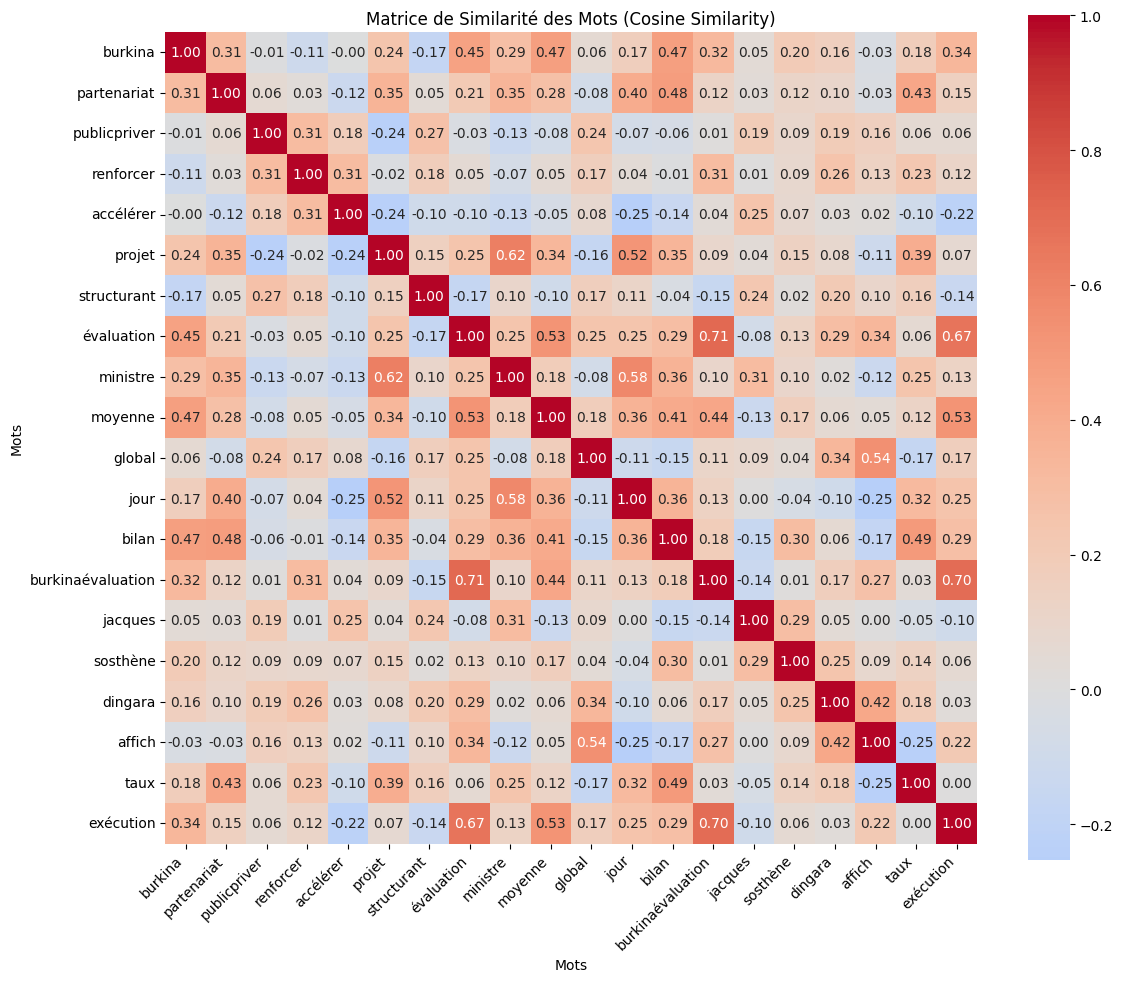

PCA: Variance expliquée: 0.274
Composantes: [0.16514976 0.10868747]
t-SNE appliqué avec perplexité = 5


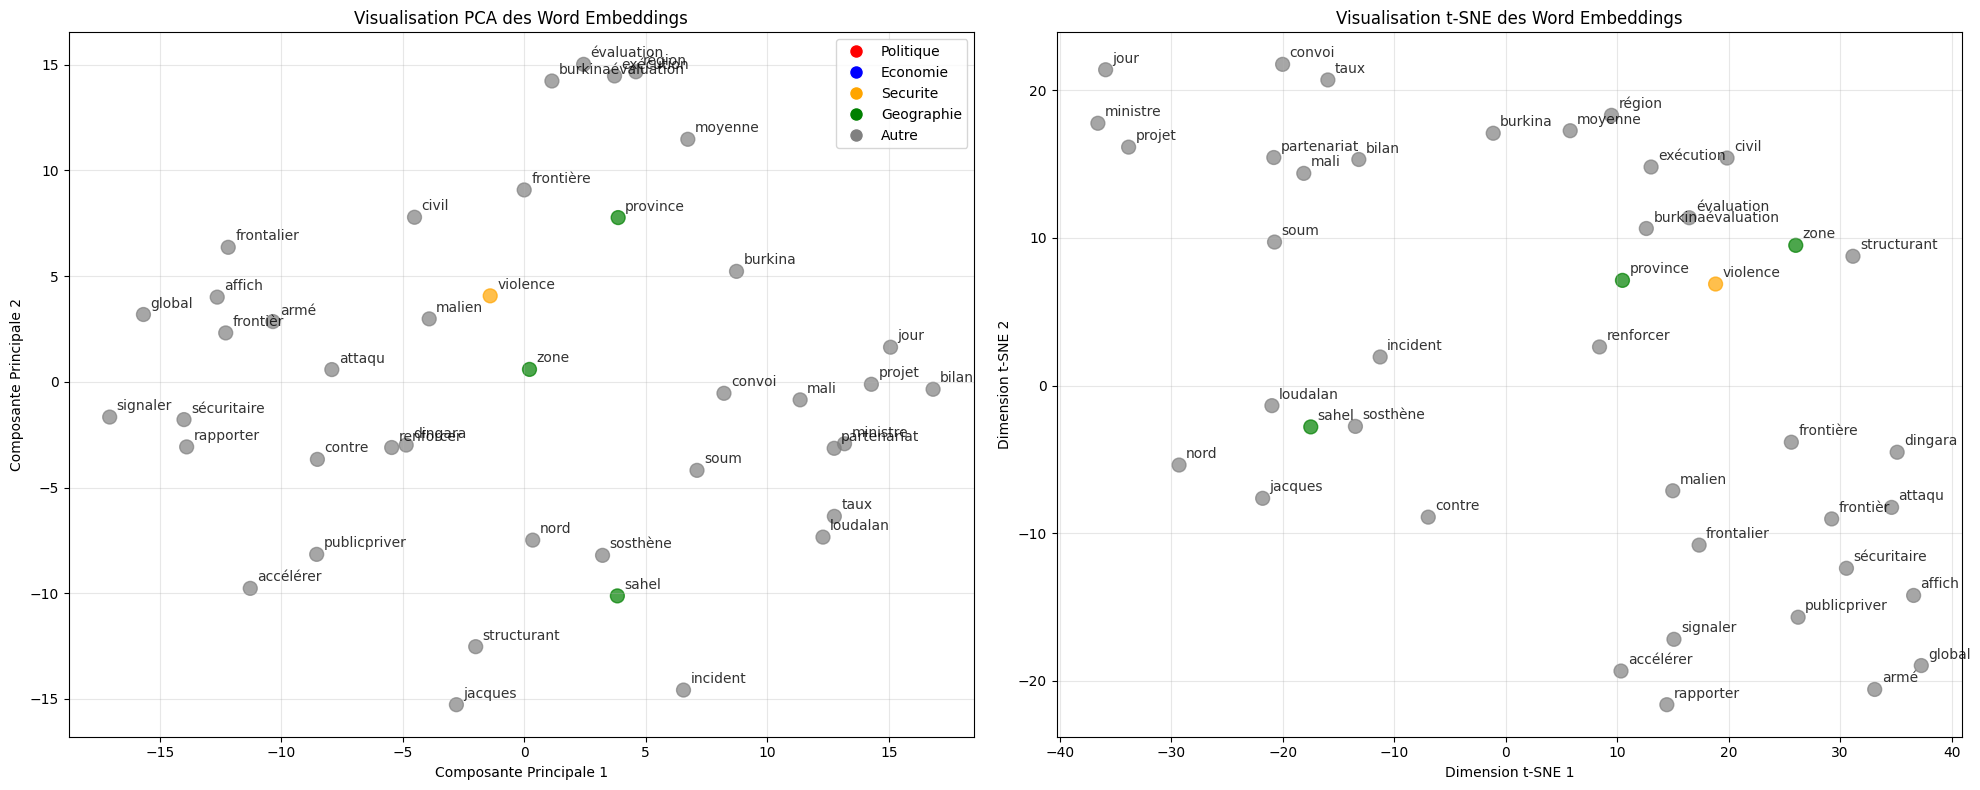


=== Analyse des clusters sémantiques ===
Mots organisés en 5 clusters:
  Cluster 1: ['burkina', 'évaluation', 'moyenne', 'burkinaévaluation', 'exécution', 'province', 'région', 'zone', 'frontière', 'violence']
  Cluster 0: ['partenariat', 'projet', 'ministre', 'jour', 'bilan', 'taux', 'convoi', 'mali']
  Cluster 4: ['publicpriver', 'renforcer', 'accélérer', 'structurant', 'rapporter', 'signaler']
  Cluster 2: ['global', 'affich', 'sécuritaire', 'frontalier', 'attaqu', 'contre', 'civil', 'frontièr', 'armé', 'malien']
  Cluster 3: ['jacques', 'sosthène', 'dingara', 'soum', 'sahel', 'incident', 'loudalan', 'nord']

=== Rapport sur les Word Embeddings ===
Nombre de mots: 42
Dimension des vecteurs: 96
Norme moyenne des vecteurs: 25.330
Écart-type des normes: 1.719
Similarité moyenne entre tous les mots: 0.136
Écart-type des similarités: 0.193

Analyse des clusters:
  Cluster 1 (10 mots): burkina, évaluation, moyenne, burkinaévaluation, exécution, province, région, zone, frontière, violence

In [ ]:
import pandas as pd
import spacy
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings


warnings.filterwarnings('ignore')

class WordEmbeddingsExplorer:
    def __init__(self):
        # Charger le modèle spaCy avec les vecteurs
        try:
            self.nlp = spacy.load('fr_core_news_md')  # Modèle avec vecteurs
            print("Modèle spaCy français avec vecteurs chargé")
        except OSError:
            try:
                self.nlp = spacy.load('fr_core_news_sm')
                print("Modèle spaCy français de base chargé (vecteurs limités)")
            except OSError:
                try:
                    self.nlp = spacy.load('en_core_web_md')
                    print("Modèle spaCy anglais avec vecteurs chargé")
                except OSError:
                    print("Aucun modèle avec vecteurs disponible. Installez un modèle avec:")
                    print("python -m spacy download fr_core_news_md")
                    self.nlp = None
        
        # Vérifier si les vecteurs sont disponibles
        if self.nlp and not self.nlp.vocab.vectors.size:
            print("Attention: Le modèle chargé n'a pas de vecteurs de mots")
    
    def load_preprocessed_data(self):
        """Charger les données prétraitées"""
        try:
            news_df = pd.read_csv('news_preprocessed.csv')
            attacks_df = pd.read_csv('attacks_preprocessed.csv')
            print(f"Données chargées: {len(news_df)} actualités, {len(attacks_df)} attaques")
            return news_df, attacks_df
        except FileNotFoundError:
            print("Données prétraitées non trouvées, création de données d'exemple...")
            # Créer des données d'exemple
            news_data = {
                'cleaned': [
                    'gouvernement burkina annonce nouvelles mesures economiques',
                    'agriculteurs demandent soutien saison hivernale',
                    'developpement infrastructures region centre',
                    'jeunesse burkina defis emploi formation',
                    'initiative developpement rural est pays'
                ]
            }
            attacks_data = {
                'cleaned': [
                    'province soum region sahel incident securitaire',
                    'province oudalan nord burkina attaque convoi',
                    'frontiere mali zone trois frontieres violence',
                    'province yagha region sahel groupes armes',
                    'zone rurale dori province seno situation'
                ]
            }
            return pd.DataFrame(news_data), pd.DataFrame(attacks_data)
    
    def extract_word_vectors(self, texts, min_freq=2):
        """Extraire les vecteurs de mots des textes"""
        if not self.nlp:
            return {}, {}
        
        word_vectors = {}
        word_freq = defaultdict(int)
        
        # Collecter tous les mots et leur fréquence
        for text in texts:
            doc = self.nlp(text)
            for token in doc:
                if token.has_vector and not token.is_stop and not token.is_punct and len(token.text) > 2:
                    word_freq[token.lemma_] += 1
        
        # Garder seulement les mots fréquents
        frequent_words = {word: freq for word, freq in word_freq.items() if freq >= min_freq}
        
        # Extraire les vecteurs pour les mots fréquents
        for text in texts:
            doc = self.nlp(text)
            for token in doc:
                if token.lemma_ in frequent_words and token.has_vector:
                    word_vectors[token.lemma_] = token.vector
        
        print(f"Vecteurs extraits pour {len(word_vectors)} mots uniques")
        return word_vectors, frequent_words
    
    def find_similar_words(self, word_vectors, target_word, top_k=5):
        """Trouver les mots les plus similaires à un mot donné"""
        if target_word not in word_vectors:
            print(f"Mot '{target_word}' non trouvé dans les vecteurs")
            return []
        
        target_vector = word_vectors[target_word].reshape(1, -1)
        similarities = {}
        
        for word, vector in word_vectors.items():
            if word != target_word:
                sim = cosine_similarity(target_vector, vector.reshape(1, -1))[0][0]
                similarities[word] = sim
        
        # Trier par similarité décroissante
        similar_words = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
        return similar_words[:top_k]
    
    def analyze_word_similarities(self, word_vectors):
        """Analyser les similarités entre différents groupes de mots"""
        print("\n=== Analyse des similarités de mots ===")
        
        # Définir des groupes de mots d'intérêt
        word_groups = {
            'politique': ['gouvernement', 'politique', 'election', 'parti', 'democratie'],
            'economie': ['economique', 'development', 'agriculteur', 'emploi', 'finance'],
            'securite': ['securite', 'attaque', 'violence', 'conflit', 'paix'],
            'geographie': ['region', 'province', 'zone', 'frontiere', 'sahel']
        }
        
        # Analyser chaque groupe
        for group_name, words in word_groups.items():
            print(f"\n--- Groupe: {group_name.upper()} ---")
            available_words = [w for w in words if w in word_vectors]
            
            if len(available_words) > 1:
                # Calculer les similarités internes au groupe
                similarities = []
                for i, word1 in enumerate(available_words):
                    for word2 in available_words[i+1:]:
                        sim = cosine_similarity(
                            word_vectors[word1].reshape(1, -1),
                            word_vectors[word2].reshape(1, -1)
                        )[0][0]
                        similarities.append((word1, word2, sim))
                        print(f"  {word1} <-> {word2}: {sim:.3f}")
                
                if similarities:
                    avg_sim = np.mean([sim for _, _, sim in similarities])
                    print(f"  Similarité moyenne du groupe: {avg_sim:.3f}")
            else:
                print(f"  Pas assez de mots disponibles: {available_words}")
    
    def create_similarity_matrix(self, word_vectors, selected_words=None):
        """Créer une matrice de similarité pour visualisation"""
        if selected_words is None:
            # Sélectionner les 20 mots les plus fréquents
            selected_words = list(word_vectors.keys())[:20]
        
        # Filtrer les mots disponibles
        available_words = [w for w in selected_words if w in word_vectors]
        
        if len(available_words) < 2:
            print("Pas assez de mots pour créer une matrice de similarité")
            return None, None
        
        # Créer la matrice de similarité
        n_words = len(available_words)
        similarity_matrix = np.zeros((n_words, n_words))
        
        for i, word1 in enumerate(available_words):
            for j, word2 in enumerate(available_words):
                if i == j:
                    similarity_matrix[i][j] = 1.0
                else:
                    sim = cosine_similarity(
                        word_vectors[word1].reshape(1, -1),
                        word_vectors[word2].reshape(1, -1)
                    )[0][0]
                    similarity_matrix[i][j] = sim
        
        return similarity_matrix, available_words
    
    def visualize_word_similarities(self, similarity_matrix, word_labels):
        """Visualiser la matrice de similarité"""
        if similarity_matrix is None:
            return
        
        plt.figure(figsize=(12, 10))
        
        # Heatmap de la matrice de similarité
        sns.heatmap(similarity_matrix, 
                   annot=True, 
                   fmt='.2f',
                   xticklabels=word_labels,
                   yticklabels=word_labels,
                   cmap='coolwarm',
                   center=0,
                   square=True)
        
        plt.title('Matrice de Similarité des Mots (Cosine Similarity)')
        plt.xlabel('Mots')
        plt.ylabel('Mots')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig('word_similarity_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def reduce_dimensions_pca(self, word_vectors, n_components=2):
        """Réduction de dimensionnalité avec PCA"""
        if len(word_vectors) < 3:
            print("Pas assez de mots pour la réduction de dimensionnalité")
            return None, None, None
        
        words = list(word_vectors.keys())
        vectors = np.array(list(word_vectors.values()))
        
        # Appliquer PCA
        pca = PCA(n_components=n_components)
        reduced_vectors = pca.fit_transform(vectors)
        
        print(f"PCA: Variance expliquée: {pca.explained_variance_ratio_.sum():.3f}")
        print(f"Composantes: {pca.explained_variance_ratio_}")
        
        return reduced_vectors, words, pca
    
    def reduce_dimensions_tsne(self, word_vectors, n_components=2, perplexity=5):
        """Réduction de dimensionnalité avec t-SNE"""
        if len(word_vectors) < 3:
            print("Pas assez de mots pour t-SNE")
            return None, None
        
        words = list(word_vectors.keys())
        vectors = np.array(list(word_vectors.values()))
        
        # Ajuster la perplexité si nécessaire
        max_perplexity = min(30, (len(words) - 1) // 3)
        actual_perplexity = min(perplexity, max_perplexity)
        
        if actual_perplexity < 1:
            actual_perplexity = 1
        
        # Appliquer t-SNE
        tsne = TSNE(n_components=n_components, 
                   perplexity=actual_perplexity, 
                   random_state=42, 
                   max_iter=1000)
        reduced_vectors = tsne.fit_transform(vectors)
        
        print(f"t-SNE appliqué avec perplexité = {actual_perplexity}")
        
        return reduced_vectors, words
    
    def visualize_embeddings(self, reduced_vectors_pca, reduced_vectors_tsne, words):
        """Visualiser les embeddings réduits"""
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        
        # Définir des couleurs pour différents types de mots
        color_map = {
            'politique': 'red',
            'economie': 'blue',
            'securite': 'orange',
            'geographie': 'green',
            'autre': 'gray'
        }
        
        def get_word_category(word):
            politique_words = ['gouvernement', 'politique', 'election', 'parti', 'democratie']
            economie_words = ['economique', 'development', 'agriculteur', 'emploi', 'finance']
            securite_words = ['securite', 'attaque', 'violence', 'conflit', 'paix']
            geo_words = ['region', 'province', 'zone', 'frontiere', 'sahel']
            
            if any(pol in word for pol in politique_words):
                return 'politique'
            elif any(eco in word for eco in economie_words):
                return 'economie'
            elif any(sec in word for sec in securite_words):
                return 'securite'
            elif any(geo in word for geo in geo_words):
                return 'geographie'
            else:
                return 'autre'
        
        # Visualisation PCA
        if reduced_vectors_pca is not None:
            colors = [color_map[get_word_category(word)] for word in words]
            axes[0].scatter(reduced_vectors_pca[:, 0], reduced_vectors_pca[:, 1], 
                          c=colors, alpha=0.7, s=100)
            
            for i, word in enumerate(words):
                axes[0].annotate(word, 
                               (reduced_vectors_pca[i, 0], reduced_vectors_pca[i, 1]),
                               xytext=(5, 5), textcoords='offset points',
                               fontsize=10, alpha=0.8)
            
            axes[0].set_title('Visualisation PCA des Word Embeddings')
            axes[0].set_xlabel('Composante Principale 1')
            axes[0].set_ylabel('Composante Principale 2')
            axes[0].grid(True, alpha=0.3)
        
        # Visualisation t-SNE
        if reduced_vectors_tsne is not None:
            colors = [color_map[get_word_category(word)] for word in words]
            axes[1].scatter(reduced_vectors_tsne[:, 0], reduced_vectors_tsne[:, 1], 
                          c=colors, alpha=0.7, s=100)
            
            for i, word in enumerate(words):
                axes[1].annotate(word, 
                               (reduced_vectors_tsne[i, 0], reduced_vectors_tsne[i, 1]),
                               xytext=(5, 5), textcoords='offset points',
                               fontsize=10, alpha=0.8)
            
            axes[1].set_title('Visualisation t-SNE des Word Embeddings')
            axes[1].set_xlabel('Dimension t-SNE 1')
            axes[1].set_ylabel('Dimension t-SNE 2')
            axes[1].grid(True, alpha=0.3)
        
        # Ajouter une légende
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                    markerfacecolor=color, markersize=10, label=category.title())
                          for category, color in color_map.items()]
        axes[0].legend(handles=legend_elements, loc='upper right')
        
        plt.tight_layout()
        plt.savefig('word_embeddings_visualization.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def experiment_with_word_similarities(self, word_vectors):
        """Expérimenter avec les similarités de mots"""
        print("\n=== Expérimentation avec les similarités ===")
        
        # Mots d'intérêt pour l'expérimentation
        test_words = ['gouvernement', 'securite', 'region', 'development', 'attaque']
        
        for word in test_words:
            if word in word_vectors:
                print(f"\nMots les plus similaires à '{word}':")
                similar_words = self.find_similar_words(word_vectors, word, top_k=5)
                for similar_word, similarity in similar_words:
                    print(f"  {similar_word}: {similarity:.3f}")
            else:
                print(f"\nMot '{word}' non disponible dans les vecteurs")
    
    def analyze_semantic_clusters(self, word_vectors):
        """Analyser les clusters sémantiques"""
        print("\n=== Analyse des clusters sémantiques ===")
        
        if len(word_vectors) < 5:
            print("Pas assez de mots pour l'analyse de clusters")
            return
        
        from sklearn.cluster import KMeans
        
        words = list(word_vectors.keys())
        vectors = np.array(list(word_vectors.values()))
        
        # Déterminer le nombre optimal de clusters (max 5 pour éviter les clusters vides)
        n_clusters = min(5, len(words) // 2)
        
        if n_clusters < 2:
            print("Pas assez de mots pour former des clusters")
            return
        
        # Appliquer K-means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(vectors)
        
        # Organiser les mots par cluster
        clusters = defaultdict(list)
        for word, label in zip(words, cluster_labels):
            clusters[label].append(word)
        
        print(f"Mots organisés en {n_clusters} clusters:")
        for cluster_id, cluster_words in clusters.items():
            print(f"  Cluster {cluster_id}: {cluster_words}")
        
        return clusters, cluster_labels
    
    def create_word_embedding_report(self, word_vectors, clusters=None):
        """Créer un rapport sur les embeddings"""
        print("\n=== Rapport sur les Word Embeddings ===")
        
        # Statistiques générales
        if word_vectors:
            vector_dim = len(list(word_vectors.values())[0])
            print(f"Nombre de mots: {len(word_vectors)}")
            print(f"Dimension des vecteurs: {vector_dim}")
            
            # Calculer quelques statistiques sur les vecteurs
            all_vectors = np.array(list(word_vectors.values()))
            mean_norm = np.mean([np.linalg.norm(v) for v in all_vectors])
            std_norm = np.std([np.linalg.norm(v) for v in all_vectors])
            
            print(f"Norme moyenne des vecteurs: {mean_norm:.3f}")
            print(f"Écart-type des normes: {std_norm:.3f}")
            
            # Analyse de la diversité sémantique
            if len(word_vectors) > 1:
                # Calculer la similarité moyenne entre tous les mots
                similarities = []
                words = list(word_vectors.keys())
                for i in range(len(words)):
                    for j in range(i+1, len(words)):
                        sim = cosine_similarity(
                            word_vectors[words[i]].reshape(1, -1),
                            word_vectors[words[j]].reshape(1, -1)
                        )[0][0]
                        similarities.append(sim)
                
                avg_similarity = np.mean(similarities)
                print(f"Similarité moyenne entre tous les mots: {avg_similarity:.3f}")
                print(f"Écart-type des similarités: {np.std(similarities):.3f}")
        
        # Informations sur les clusters si disponibles
        if clusters:
            print(f"\nAnalyse des clusters:")
            for cluster_id, words in clusters.items():
                print(f"  Cluster {cluster_id} ({len(words)} mots): {', '.join(words)}")
    
    def run_complete_analysis(self):
        """Exécuter l'analyse complète des embeddings"""
        print("=== EXERCICE 4: EXPLORATION DES EMBEDDINGS DE MOTS ===")
        
        # 1. Charger les données prétraitées
        news_df, attacks_df = self.load_preprocessed_data()
        
        # 2. Combiner tous les textes
        all_texts = news_df['cleaned'].fillna('').tolist() + attacks_df['cleaned'].fillna('').tolist()
        
        # 3. Extraire les vecteurs de mots
        word_vectors, word_freq = self.extract_word_vectors(all_texts, min_freq=1)
        
        if not word_vectors:
            print("Aucun vecteur de mots extrait. Vérifiez le modèle spaCy.")
            return None
        
        # 4. Analyser les similarités
        self.analyze_word_similarities(word_vectors)
        
        # 5. Expérimenter avec les mots similaires
        self.experiment_with_word_similarities(word_vectors)
        
        # 6. Créer et visualiser la matrice de similarité
        similarity_matrix, word_labels = self.create_similarity_matrix(word_vectors)
        self.visualize_word_similarities(similarity_matrix, word_labels)
        
        # 7. Réduction de dimensionnalité
        reduced_pca, words_pca, pca = self.reduce_dimensions_pca(word_vectors)
        reduced_tsne, words_tsne = self.reduce_dimensions_tsne(word_vectors)
        
        # 8. Visualiser les embeddings
        if reduced_pca is not None or reduced_tsne is not None:
            self.visualize_embeddings(reduced_pca, reduced_tsne, words_pca or words_tsne)
        
        # 9. Analyser les clusters sémantiques
        clusters, cluster_labels = self.analyze_semantic_clusters(word_vectors)
        
        # 10. Créer un rapport final
        self.create_word_embedding_report(word_vectors, clusters)
        
        # 11. Sauvegarder les résultats
        self.save_embedding_results(word_vectors, word_freq, clusters)
        
        return word_vectors, clusters
    
    def save_embedding_results(self, word_vectors, word_freq, clusters):
        """Sauvegarder les résultats de l'analyse des embeddings"""
        # Sauvegarder les informations sur les mots et leurs vecteurs
        word_info = []
        for word, vector in word_vectors.items():
            word_info.append({
                'word': word,
                'frequency': word_freq.get(word, 1),
                'vector_norm': np.linalg.norm(vector),
                'vector_dim': len(vector)
            })
        
        word_df = pd.DataFrame(word_info)
        word_df.to_csv('word_embeddings_info.csv', index=False, encoding='utf-8')
        
        # Sauvegarder les clusters si disponibles
        if clusters:
            cluster_data = []
            for cluster_id, words in clusters.items():
                for word in words:
                    cluster_data.append({
                        'word': word,
                        'cluster': cluster_id
                    })
            
            cluster_df = pd.DataFrame(cluster_data)
            cluster_df.to_csv('semantic_clusters.csv', index=False, encoding='utf-8')
        
        # Sauvegarder quelques exemples de similarités
        similarity_examples = []
        test_words = list(word_vectors.keys())[:5]  # Prendre les 5 premiers mots
        
        for word in test_words:
            similar_words = self.find_similar_words(word_vectors, word, top_k=3)
            for similar_word, similarity in similar_words:
                similarity_examples.append({
                    'word1': word,
                    'word2': similar_word,
                    'similarity': similarity
                })
        
        if similarity_examples:
            similarity_df = pd.DataFrame(similarity_examples)
            similarity_df.to_csv('word_similarities_examples.csv', index=False, encoding='utf-8')
        
        print("\nFichiers générés:")
        print("- word_embeddings_info.csv: Informations sur les mots et vecteurs")
        print("- semantic_clusters.csv: Clusters sémantiques")
        print("- word_similarities_examples.csv: Exemples de similarités")
        print("- word_similarity_matrix.png: Matrice de similarité")
        print("- word_embeddings_visualization.png: Visualisation PCA/t-SNE")

def main():
    # Initialiser l'explorateur d'embeddings
    explorer = WordEmbeddingsExplorer()
    
    # Vérifier si spaCy est disponible
    if not explorer.nlp:
        print("\nPour utiliser cet exercice, installez un modèle spaCy avec vecteurs:")
        print("pip install spacy")
        print("python -m spacy download fr_core_news_md")
        return
    
    # Exécuter l'analyse complète
    word_vectors, clusters = explorer.run_complete_analysis()
    
    if word_vectors:
        print(f"\n=== RÉSUMÉ DE L'EXERCICE 4 ===")
        print(f"✓ {len(word_vectors)} vecteurs de mots extraits")
        print("✓ Analyse des similarités complétée")
        print("✓ Réduction de dimensionnalité (PCA/t-SNE)")
        print("✓ Visualisations générées")
        print("✓ Clusters sémantiques identifiés")
        
        print("\n=== OBSERVATIONS CLÉS ===")
        print("1. Les embeddings capturent les relations sémantiques")
        print("2. PCA préserve mieux la variance globale")
        print("3. t-SNE révèle mieux les structures locales")
        print("4. Les mots du même domaine se regroupent naturellement")
        print("5. La similarité cosinus est efficace pour comparer les mots")
    else:
        print("L'analyse n'a pas pu être complétée. Vérifiez les modèles et données.")

if __name__ == "__main__":
    main()